In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from pycm import ConfusionMatrix, Compare

In [6]:
!pip install pycm
!pip install shap


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/1e/86/d41993abadf5f31173066b1d32ee1a944545144d448f4a11d68f730f38f5/shap-0.43.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/f8/14/546925a397d7638858a890a01d82cc6de147fca294eccf93ee11b524ca3c/numba-0.58.1-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for cloudpickle from https://files.pythonhosted.org/packages/96/43/dae06432d0c4b1dc9e9149ad37b4ca8384cf6eb7700cd9215b177b914f0a/cloudpickle-3.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for llvmlite<0.42,>=0.41.0dev0 from https://files.pythonhosted.org/packages/88/99/aa829162a871f0f91dba9a0344726449cafbff4e9e55d7a714051cbb6215/llvmlite-0.41.1-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 0.0/447.3 kB ? eta -:--:--
   --------------------------------------- 447.3/447.3 kB 14.1 MB/s eta 0:00:00
   --------


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
df = pd.read_csv(r"C:\Users\limng\Desktop\bt4012 github\bt4012-group13\data\processed\kaggle_transaction_dataset.csv")

In [4]:
FOLD_NUMBER = 10
RANDOM_STATE = 23
METRIC_LIST = ["Accuracy", "F1", "Kappa", "Precision", "Recall"]

In [5]:
# Sampling due to imbalanced dataset

positive_sample = df[df["flag"] == 1]
negative_sample = df[df["flag"] == 0].sample(len(positive_sample), random_state = RANDOM_STATE)
data = pd.concat([negative_sample, positive_sample], axis = 0)
y = data["flag"]
X = data.iloc[:,2:]

In [7]:
#KNN model

knn_params = {"n_neighbors": 15}

knn_model = KNeighborsClassifier(**knn_params)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
knn_cm_worst = None
knn_cm_best = None
knn_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    knn_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = knn_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    knn_cm_list.append(cm)
    if knn_cm_worst is None:
        knn_cm_worst = cm
    else:
        if cm.Overall_ACC < knn_cm_worst.Overall_ACC:
            knn_cm_worst = cm

    if knn_cm_best is None:
        knn_cm_best = cm
    else:
        if cm.Overall_ACC > knn_cm_best.Overall_ACC:
            knn_cm_best = cm

In [15]:
#KNN with shapley values

import shap

RANDOM_STATE = 42

knn_params = {"n_neighbors": 15}

knn_model = KNeighborsClassifier(**knn_params)
kf = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
cm_metric_list = []
knn_cm_worst = None
knn_cm_best = None
knn_cm_list = []

# Summarize the background data using shap.sample
background_samples = shap.sample(X, 50)  # Replace K with an appropriate value

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    knn_model.fit(X_train, y_train)
    cm = ConfusionMatrix(
        actual_vector=y_test.values, predict_vector=knn_model.predict(X_test)
    )
    cm_metric_list.append(
        {
            "Accuracy": cm.Overall_ACC,
            "F1": cm.F1[1],
            "Kappa": cm.Kappa,
            "Precision": cm.PPV[1],
            "Recall": cm.TPR[1],
        }
    )
    cm.relabel({1: "Fraud", 0: "Non-Fraud"})
    knn_cm_list.append(cm)

    if knn_cm_worst is None:
        knn_cm_worst = cm
    else:
        if cm.Overall_ACC < knn_cm_worst.Overall_ACC:
            knn_cm_worst = cm

    if knn_cm_best is None:
        knn_cm_best = cm
    else:
        if cm.Overall_ACC > knn_cm_best.Overall_ACC:
            knn_cm_best = cm

    # Calculate Shapley values
    explainer = shap.KernelExplainer(knn_model.predict, background_samples)
    shap_values = explainer.shap_values(X_test)

  0%|          | 0/1466 [00:00<?, ?it/s]

KeyboardInterrupt: 

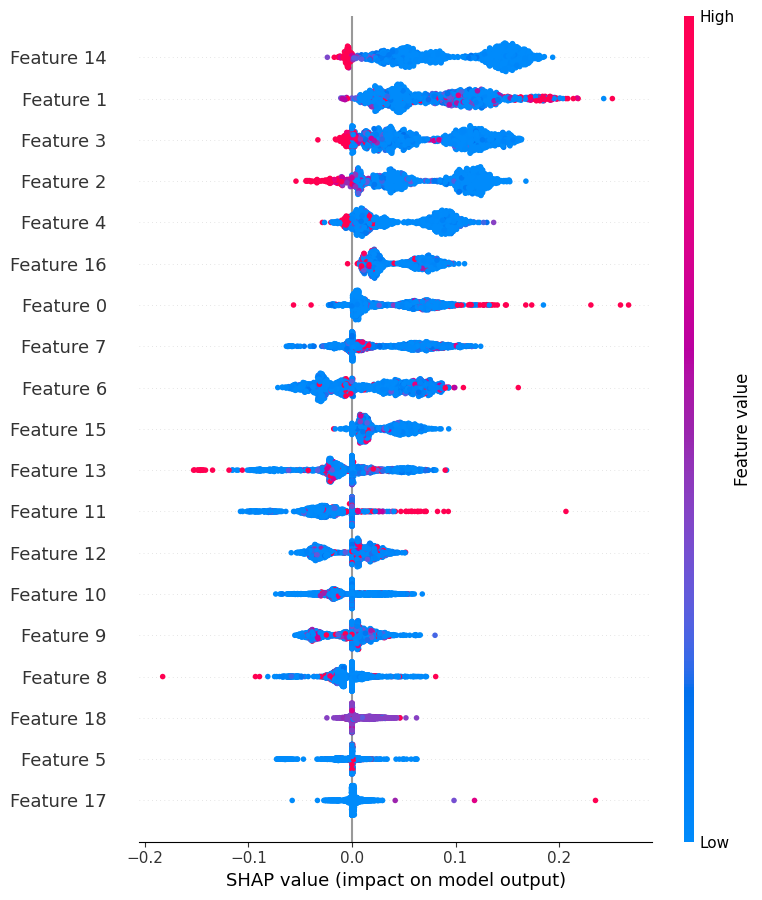

In [11]:
shap.summary_plot(shap_values, X_test)
plt.show()


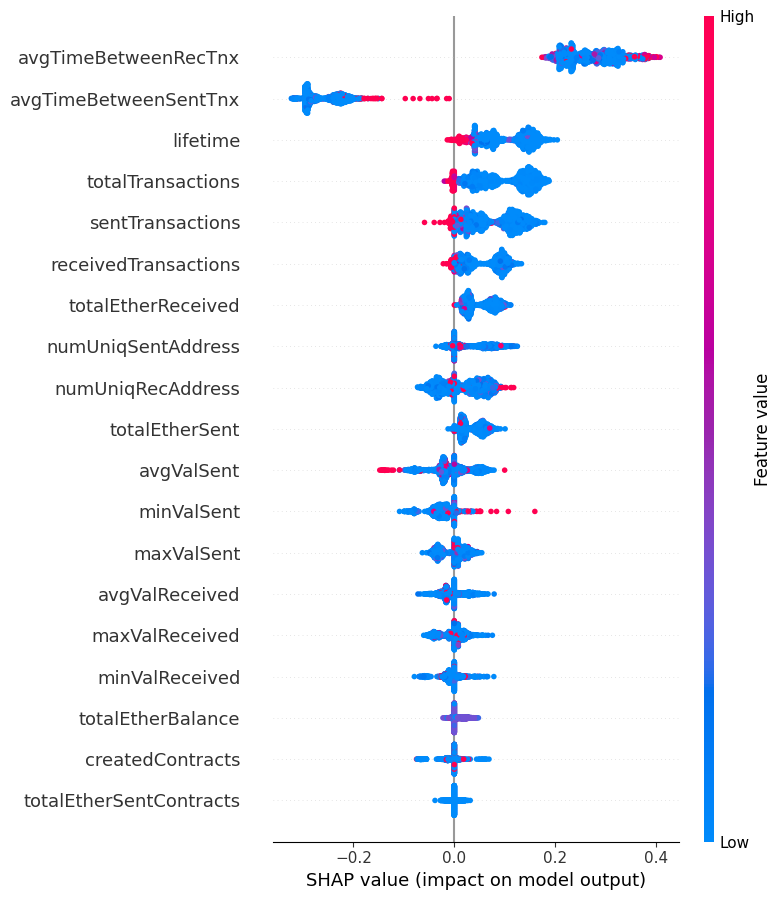

In [26]:
import shap
import matplotlib.pyplot as plt

# Assuming you have already calculated SHAP values and stored them in the 'shap_values' variable

# Get feature names (assuming X is a DataFrame)
feature_names = X.columns

# Summary Plot for Feature Importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Individual Prediction Explanations (replace 'sample_index' with the index of the data point you want to explain)
sample_index = 0  # Choose an index to explain
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test[sample_index])




plt.show()


Model Name: KNN Classifier

10-Fold Metrics: 

Accuracy : 0.86

F1 : 0.86

Kappa : 0.72

Precision : 0.86

Recall : 0.86



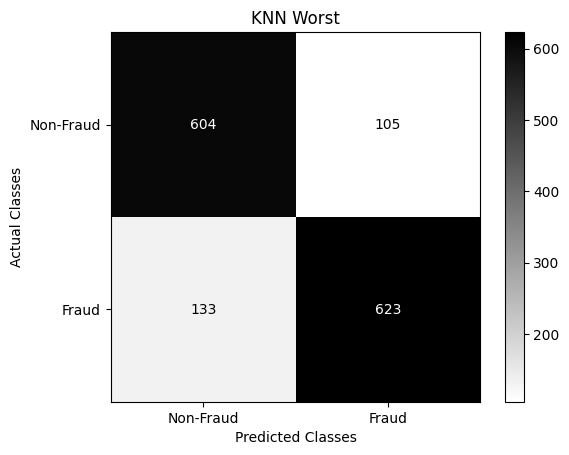

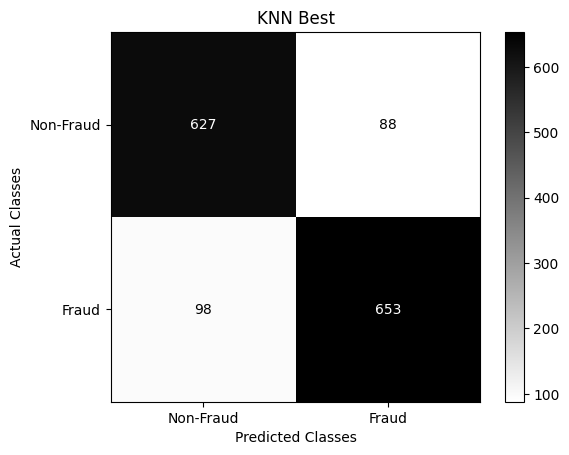

In [13]:
print("Model Name: KNN Classifier\n")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
knn_cm_worst.plot(title="KNN Worst", number_label=True)
knn_cm_best.plot(title="KNN Best", number_label=True)
plt.show()

In [21]:
#Random forest model
rf_params = {"n_estimators": 150, "criterion": "entropy", "bootstrap": True}

rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X, y)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
rf_cm_worst = None
rf_cm_best = None
rf_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    rf_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = rf_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    rf_cm_list.append(cm)
    if rf_cm_worst is None:
        rf_cm_worst = cm
    else:
        if cm.Overall_ACC < rf_cm_worst.Overall_ACC:
            rf_cm_worst = cm

    if rf_cm_best is None:
        rf_cm_best = cm
    else:
        if cm.Overall_ACC > rf_cm_best.Overall_ACC:
            rf_cm_best = cm

Model Name: Random Forest Classifier

10-Fold Metrics: 

Accuracy : 0.85

F1 : 0.86

Kappa : 0.7

Precision : 0.83

Recall : 0.89



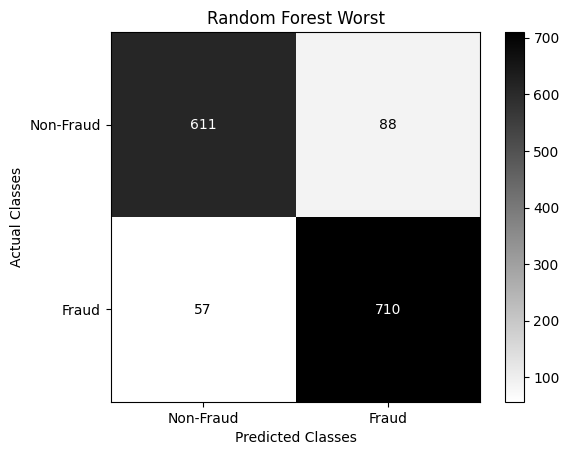

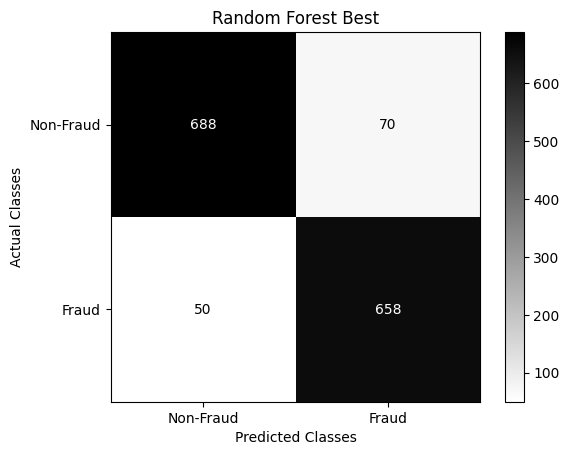

In [28]:
print("Model Name: Random Forest Classifier\n")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
rf_cm_worst.plot(title="Random Forest Worst", number_label=True)
rf_cm_best.plot(title="Random Forest Best", number_label=True)
plt.show()

In [30]:
#feature importance
pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

lifetime                   0.127322
numUniqRecAddress          0.101631
totalTransactions          0.095368
avgTimeBetweenRecTnx       0.087333
sentTransactions           0.060368
avgValSent                 0.060289
avgValReceived             0.059154
minValReceived             0.050319
totalEtherReceived         0.049408
receivedTransactions       0.047492
maxValSent                 0.043291
minValSent                 0.041901
maxValReceived             0.041390
avgTimeBetweenSentTnx      0.040614
totalEtherSent             0.036238
numUniqSentAddress         0.025759
totalEtherBalance          0.024345
createdContracts           0.007712
totalEtherSentContracts    0.000068
dtype: float64

In [27]:
#tuned RF model

from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 42

# Define hyperparameter grid for the Random Forest
param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}


grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True),
    scoring='accuracy', 
    n_jobs=-1  # Use all available CPU cores for faster search
)


grid_search.fit(X, y)
best_rf_params = grid_search.best_params_
tuned_rf_model = RandomForestClassifier(**best_rf_params)

# Initialize KFold for cross-validation
kf = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
cm_metric_list = []
rf_cm_worst = None
rf_cm_best = None
rf_cm_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    tuned_rf_model.fit(X_train, y_train)
    cm = ConfusionMatrix(
        actual_vector=y_test.values, predict_vector=tuned_rf_model.predict(X_test)
    )
    cm_metric_list.append(
        {
            "Accuracy": cm.Overall_ACC,
            "F1": cm.F1[1],
            "Kappa": cm.Kappa,
            "Precision": cm.PPV[1],
            "Recall": cm.TPR[1],
        }
    )
    cm.relabel({1: "Fraud", 0: "Non-Fraud"})
    rf_cm_list.append(cm)

    if rf_cm_worst is None:
        rf_cm_worst = cm
    else:
        if cm.Overall_ACC < rf_cm_worst.Overall_ACC:
            rf_cm_worst = cm

    if rf_cm_best is None:
        rf_cm_best = cm
    else:
        if cm.Overall_ACC > rf_cm_best.Overall_ACC:
            rf_cm_best = cm

Model Name: Tuned Random Forest Classifier

10-Fold Metrics: 

Accuracy : 0.86

F1 : 0.87

Kappa : 0.71

Precision : 0.82

Recall : 0.92



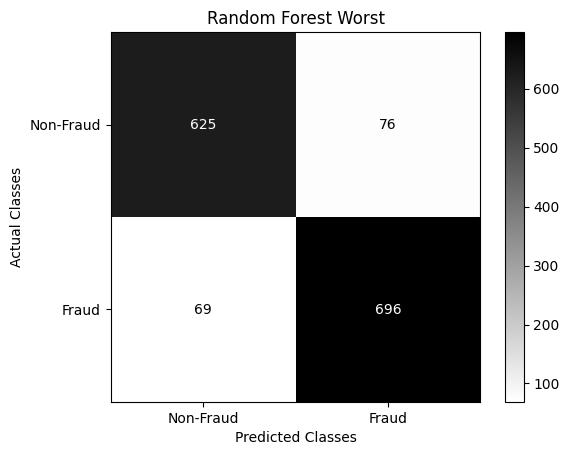

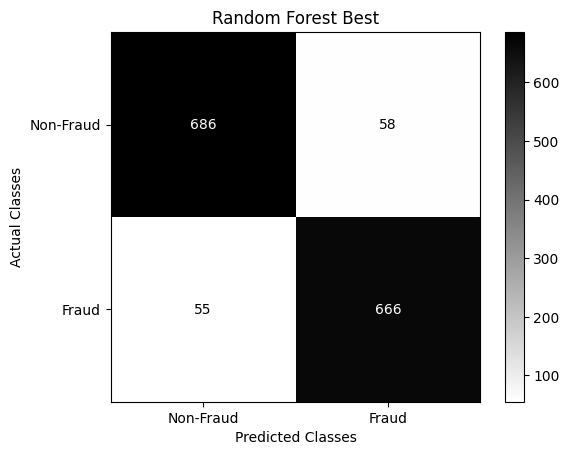

In [31]:
#metrics for tuned rf model
print("Model Name: Tuned Random Forest Classifier\n")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
rf_cm_worst.plot(title="Random Forest Worst", number_label=True)
rf_cm_best.plot(title="Random Forest Best", number_label=True)
plt.show()

In [29]:
#feature importance for tuned RF model

pd.Series(tuned_rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

lifetime                   0.137696
totalTransactions          0.103358
numUniqRecAddress          0.096490
avgTimeBetweenRecTnx       0.082551
sentTransactions           0.062090
avgValSent                 0.060503
avgValReceived             0.055976
totalEtherReceived         0.054768
minValReceived             0.047367
maxValReceived             0.045375
receivedTransactions       0.043324
avgTimeBetweenSentTnx      0.041899
minValSent                 0.041799
maxValSent                 0.039525
totalEtherSent             0.031398
numUniqSentAddress         0.025019
totalEtherBalance          0.023293
createdContracts           0.007400
totalEtherSentContracts    0.000169
dtype: float64

In [29]:
# Neural network model

nn_params = {"hidden_layer_sizes": (100, 100), "solver": "adam"}

nn_model = MLPClassifier(**nn_params)
# nn_model.fit(X, y)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
nn_cm_worst = None
nn_cm_best = None
nn_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    nn_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = nn_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    nn_cm_list.append(cm)
    if nn_cm_worst is None:
        nn_cm_worst = cm
    else:
        if cm.Overall_ACC < nn_cm_worst.Overall_ACC:
            nn_cm_worst = cm

    if nn_cm_best is None:
        nn_cm_best = cm
    else:
        if cm.Overall_ACC > nn_cm_best.Overall_ACC:
            nn_cm_best = cm

c:\Users\limng\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Name: Neural Network Classifier
10-Fold Metrics: 

Accuracy : 0.86

F1 : 0.86

Kappa : 0.71

Precision : 0.82

Recall : 0.92



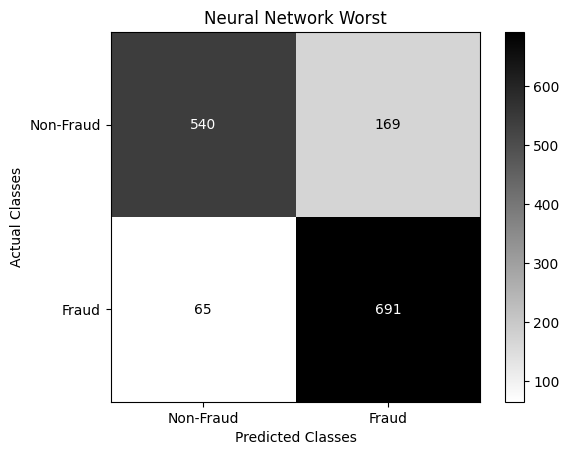

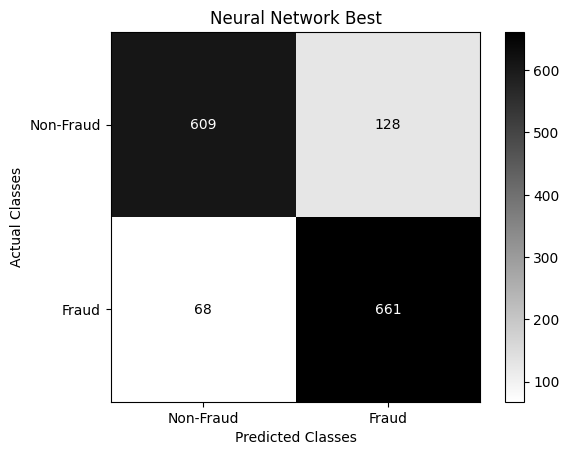

In [31]:
print("Model Name: Neural Network Classifier")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
nn_cm_worst.plot(title="Neural Network Worst", number_label=True)
nn_cm_best.plot(title="Neural Network Best", number_label=True)
plt.show()

In [30]:
#tuned NN model
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


RANDOM_STATE = 42
param_grid = {
    'hidden_layer_sizes': [(100, 100), (50, 50), (100, 50)],
    'solver': ['adam', 'lbfgs'],  
}


grid_search = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True),
    scoring='accuracy',  
    n_jobs=-1  
)


scaler = StandardScaler()
cm_metric_list = []
nn_cm_worst = None
nn_cm_best = None
nn_cm_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    grid_search.fit(X_train, y_train)
    best_nn_params = grid_search.best_params_
    tuned_nn_model = MLPClassifier(**best_nn_params)
    tuned_nn_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector=y_test.values, predict_vector=tuned_nn_model.predict(X_test))
    cm_metric_list.append({
        "Accuracy": cm.Overall_ACC,
        "F1": cm.F1[1],
        "Kappa": cm.Kappa,
        "Precision": cm.PPV[1],
        "Recall": cm.TPR[1]
    })
    cm.relabel({1: "Fraud", 0: "Non-Fraud"})
    nn_cm_list.append(cm)
    
    if nn_cm_worst is None:
        nn_cm_worst = cm
    else:
        if cm.Overall_ACC < nn_cm_worst.Overall_ACC:
            nn_cm_worst = cm

    if nn_cm_best is None:
        nn_cm_best = cm
    else:
        if cm.Overall_ACC > nn_cm_best.Overall_ACC:
            nn_cm_best = cm

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Model Name: Tuned Neural Network Classifier
10-Fold Metrics: 

Accuracy : 0.86

F1 : 0.87

Kappa : 0.71

Precision : 0.82

Recall : 0.92



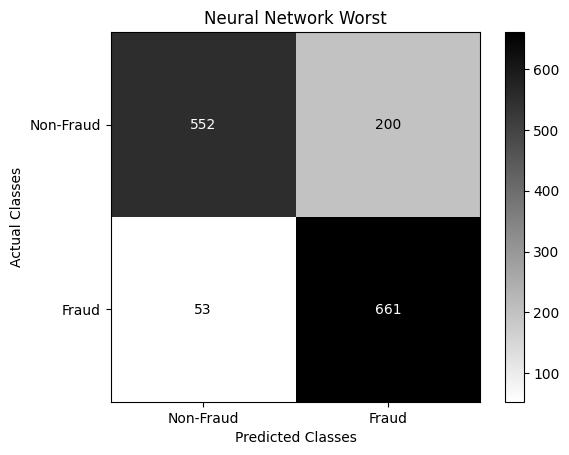

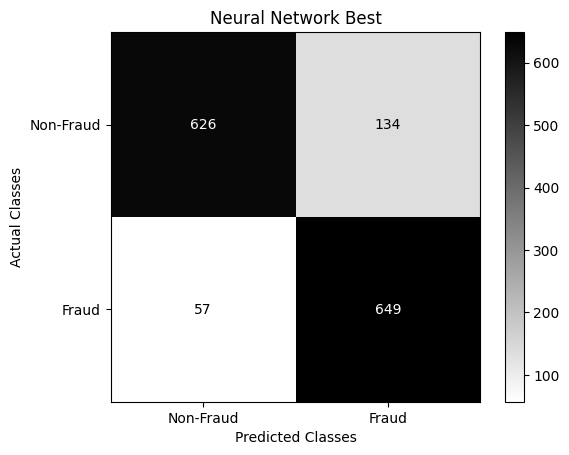

In [32]:
#metrics for tuned model
print("Model Name: Tuned Neural Network Classifier")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
nn_cm_worst.plot(title="Neural Network Worst", number_label=True)
nn_cm_best.plot(title="Neural Network Best", number_label=True)
plt.show()

In [32]:
#Ranking the three models

rf_combined_cm = None
nn_combined_cm = None
knn_combined_cm = None
for index, cm in enumerate(rf_cm_list):
    if rf_combined_cm is None:
        rf_combined_cm = cm
    else:
        rf_combined_cm = rf_combined_cm.combine(cm)
    
    if nn_combined_cm is None:
        nn_combined_cm = nn_cm_list[index]
    else:
        nn_combined_cm = nn_combined_cm.combine(nn_cm_list[index])
    
    if knn_combined_cm is None:
        knn_combined_cm = knn_cm_list[index]
    else:
        knn_combined_cm = knn_combined_cm.combine(knn_cm_list[index])

In [33]:
cp = Compare({"Random Forest":rf_combined_cm, "Neural Network":nn_combined_cm, "KNN":knn_combined_cm})
print(cp)

Best : Random Forest

Rank   Name              Class-Score       Overall-Score
1      Random Forest     0.84167           0.92381
2      KNN               0.725             0.78095
3      Neural Network    0.68333           0.78095

